# 山科录取成绩分析

## 导入库

In [2]:
import requests
from lxml import html
import re
import urllib
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from pyecharts import Map

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "D:\anaconda\envs\tensorflow_gpu\lib\site-packages\lml\utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


## 从官网拉取数据到本地

In [2]:
###山科招生在线官网网址
url = 'http://zs.sdust.edu.cn/'
html_data= requests.get(url)
html_data.encoding='utf-8'
html_data=html_data.text
#print(html_data)

### 剥离有效信息

In [3]:


##由于tbody，tr，td标签特殊性，使用常规xpath方法未能获取成功，改用正则表达式方法获取url
res_tr = r'<td height="20"><a href="(info/1021/24\d+.htm)"'
m_tr = re.compile(res_tr)
#提取出网址尾号和网址title
link_list = ['http://zs.sdust.edu.cn/'+link for link in m_tr.findall(html_data)]
del link_list[0]
print(link_list)
#从每个详细网页提取有效信息
Xp_list=[['//*[@id="vsb_content"]/div/div[1]/div[1]/div/div/div/div/div/a/@href','//*[@id="vsb_content"]/div/div[1]/div[1]/div/div/div/div/div/a/font/text()'],
         ['//*[@id="vsb_content"]/div/div[1]/div/div/div/div/div/a/@href','//*[@id="vsb_content"]/div/div[1]/div/div/div/div/div/a/font/text()'],
         ['//*[@id="vsb_content"]/div/div/div/div/div/div/a/@href','//*[@id="vsb_content"]/div/div/div/div/div/div/a/font/text()'],
         ['//*[@id="vsb_content"]/div/div/div/div/a/@href','//*[@id="vsb_content"]/div/div/div/div/a/font/text()']]

['http://zs.sdust.edu.cn/info/1021/2428.htm', 'http://zs.sdust.edu.cn/info/1021/2426.htm', 'http://zs.sdust.edu.cn/info/1021/2423.htm', 'http://zs.sdust.edu.cn/info/1021/2420.htm']


### 根据提取的连接和/xpath下载xls文件

In [4]:
#根据提取的连接和/xpath下载xls文件
i=0
for link in link_list:
    link_data = requests.get(link)
    link_data.encoding = 'utf-8'
    link_data = link_data.text
    #print(link_data)
    selector = html.fromstring(link_data)
    dlink='http://zs.sdust.edu.cn'+selector.xpath(Xp_list[i][0])[0]
    dtt = selector.xpath(Xp_list[i][1])[0]
    i+=1
    
    print(dlink,dtt)
    #将文件下载至本地
    urllib.request.urlretrieve(dlink,'D:\\tf_gpu_jupyter\\练手项目\\山科录取数据分析\\下载数据\\'+ dtt+'.xls')


http://zs.sdust.edu.cn/__local/1/C0/39/243804D6F1F6AB451236F71E958_055BEDD0_F000.xls?e=.xls 山东科技大学二〇一六年录取情况统计表
http://zs.sdust.edu.cn/__local/E/2E/5E/0417FBD368B86FF4C01A88A828B_FD4EFD92_D200.xls?e=.xls 山东科技大学二〇一五年录取情况统计表
http://zs.sdust.edu.cn/__local/B/EA/2F/7B06B052B0A56FC2EFA5D0F56BA_851AD149_D000.xls?e=.xls 山东科技大学二〇一四年录取情况统计表
http://zs.sdust.edu.cn/__local/7/B1/71/89F2133F73F10ED6EA915860F1B_720E74E6_E200.xls?e=.xls 山东科技大学二〇一三年录取情况统计表


## 从本地导入数据

### 省内数据处理


In [3]:
exc16=pd.read_excel('山东科技大学二〇一六年录取情况统计表.xls')
exc16['Unnamed: 3'][0]='科类二'
excin = exc16[0:29]
excin.columns=excin.iloc[0]
excin=excin.drop([0,])
excin=excin[['科类','科类二','计划','录取','投档最高','投档最低','录取\n分数','平均']]
excin['科类']=excin['科类'].fillna(method='ffill')
excin['投档最高']=excin['投档最高'].fillna(method='ffill')
excin['投档最低']=excin['投档最低'].fillna(method='ffill')
#使用多级index
excin.index=[excin['科类'],excin['科类二']]
del excin['科类'],excin['科类二']
excin

0                            计划    录取     投档最高     投档最低     录取\n分数     平均
科类           科类二                                                         
本科提前批        综合评价文科          57    57    81.68      NaN      74.68    NaN
             综合评价理科         123   123    84.72      NaN      76.12    NaN
本科一批\n       文科             532   557      576      544        544    549
             理科            4095  4271      615      568        568    577
             贫困专项理科         160   165      581      537        537    545
艺术类\n        视觉传达设计（文）       33    33  483/269  317/190    324/190    227
             环境设计（文）         33    33  483/269  317/190  317/204.7    245
             产品设计（文）         23    23  483/269  317/190  383/190.7    229
             视觉传达设计（理）        7     7  478/285  294/195    294/208    238
             环境设计（理）          7     7  478/285  294/195  330/195.3    255
             产品设计（理）          7     7  478/285  294/195    396/202    234
             音乐学（文）          30    25      446      310   310/76.7   81.4
             音乐学（理）          10    12      387      304   304/73.9   77.7
本科二批         文科             215   227      548      519        519  526.1
             理科             885   927      594      524        524  533.7
煤炭定向         理科              80    84      561      470        470  498.7
中外合作本科       文科             145   165      523      503        503  509.7
             理科             265   280      552      504        504  516.9
校企合作本科       文科              80    62      549      530        530  535.1
             理科             200   229      546      489        489  504.9
春季高考本科计划     测绘工程（03采矿技术）    10    10      636      532        532  562.5
             测绘工程（04土建）      30    32      627      609        609  616.7
本二（泰山科技学院）   文科             182   191      500      474        474  479.6
             理科             266   275      532      453        453  463.7
专科（泰山科技学院）   理科             300   279      453      176        176  327.1
春季高考（泰山科技学院） 机械电子工程          40    42      598      553        553  561.9
             电气工程及其自动化       40    42      622      603        603  609.7
             会计学             40    42      649      632        632    637

### 遇到matplotlib显示乱码，使用显示中文函数

In [4]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus'] = False

### 绘制计划与录取图

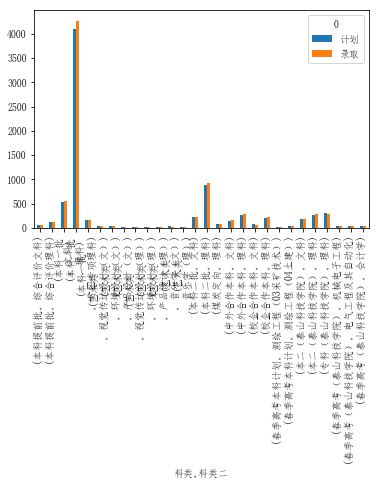

In [5]:

excin.plot(kind='bar')
plt.show()

### 因艺术类有艺考成绩与高考成绩，转向处理其他正常数据

In [6]:
excin_without_art=excin.drop(['艺术类\n'])
excin_without_art

D:\anaconda\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  """Entry point for launching an IPython kernel.


0                            计划    录取   投档最高 投档最低 录取\n分数     平均
科类           科类二                                               
本科提前批        综合评价文科          57    57  81.68  NaN  74.68    NaN
             综合评价理科         123   123  84.72  NaN  76.12    NaN
本科一批\n       文科             532   557    576  544    544    549
             理科            4095  4271    615  568    568    577
             贫困专项理科         160   165    581  537    537    545
本科二批         文科             215   227    548  519    519  526.1
             理科             885   927    594  524    524  533.7
煤炭定向         理科              80    84    561  470    470  498.7
中外合作本科       文科             145   165    523  503    503  509.7
             理科             265   280    552  504    504  516.9
校企合作本科       文科              80    62    549  530    530  535.1
             理科             200   229    546  489    489  504.9
春季高考本科计划     测绘工程（03采矿技术）    10    10    636  532    532  562.5
             测绘工程（04土建）      30    32    627  609    609  616.7
本二（泰山科技学院）   文科             182   191    500  474    474  479.6
             理科             266   275    532  453    453  463.7
专科（泰山科技学院）   理科             300   279    453  176    176  327.1
春季高考（泰山科技学院） 机械电子工程          40    42    598  553    553  561.9
             电气工程及其自动化       40    42    622  603    603  609.7
             会计学             40    42    649  632    632    637

### 绘制除去艺术类的投档最高分图

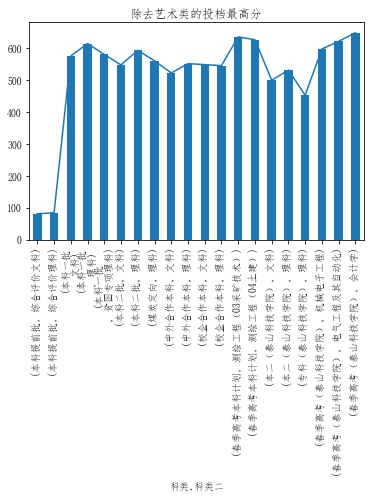

In [7]:
excin_without_art['投档最高']=excin_without_art['投档最高'].astype(float)
excin_without_art['投档最高'].plot()
excin_without_art['投档最高'].plot(kind='bar',title='除去艺术类的投档最高分')
plt.show()

### 绘制除去艺术类的录取分数图

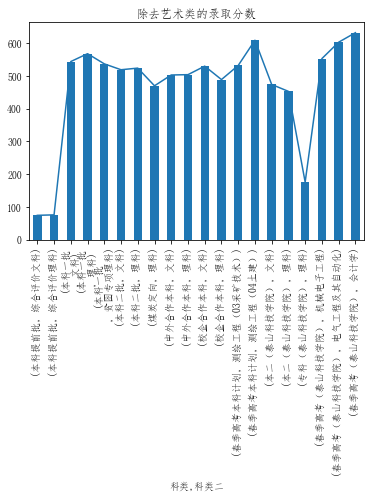

In [8]:
excin_without_art['录取\n分数']=excin_without_art['录取\n分数'].astype(float)
excin_without_art['录取\n分数'].plot()
excin_without_art['录取\n分数'].plot(kind='bar',title='除去艺术类的录取分数')
plt.show()

### 绘制除去艺术类和本科提前批的投档最低分图

D:\anaconda\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  


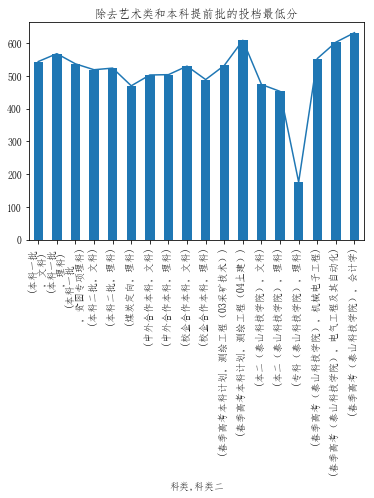

In [9]:

excin_without_artAndpre=excin_without_art.drop(['本科提前批',])
excin_without_artAndpre['投档最低']=excin_without_artAndpre['投档最低'].astype(float)
excin_without_artAndpre['投档最低'].astype(float).plot()
excin_without_artAndpre['投档最低'].plot(kind='bar',title='除去艺术类和本科提前批的投档最低分')
plt.show()


### 绘制除去本科提前批的平均分图

D:\anaconda\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  """Entry point for launching an IPython kernel.


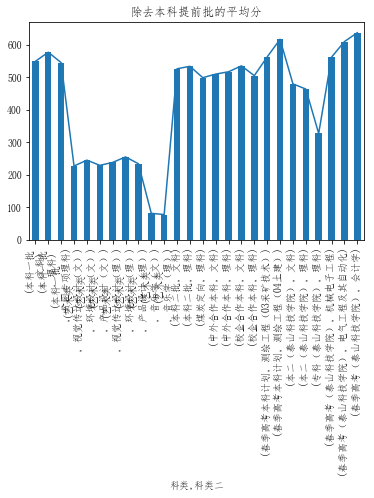

In [10]:
excin_without_pre=excin.drop(['本科提前批',])
excin_without_pre['平均']=excin_without_pre['平均'].astype(float)
excin_without_pre['平均'].astype(float).plot()
excin_without_pre['平均'].plot(kind='bar',title='除去本科提前批的平均分')
plt.show()

## 省外数据处理

In [11]:
excout = exc16[32:]
excout.columns=excout.iloc[0]
excout=excout.drop([32])
excout[['省码','省市','批次']]=excout[['省码','省市','批次']].fillna(method='ffill')
excout = excout.drop([58,67])
excout = excout.fillna(method='ffill',axis=1)
excout.index = [excout['省市'],excout['科类']]
del excout['省码'],excout['科类']
excout

32        省市   计划   批次 一志愿录取 二志愿录取   投档最高   投档最低   录取分数      平均  二本线  一本线
省市  科类                                                                   
北京  文科    北京    2   二本     2     0    568    568    532     568  532  583
    理科    北京    5   二本     5     0    528    519    519   524.1  494  548
天津  文科    天津   14   二本    14     0    516    493    493   500.4  460  532
    理科    天津   16   二本    16     0    530    485    485   495.9  424  512
河北  文科    河北   17   一本    17     0    586    570    570   577.4  416  535
    理科    河北  123   一本   123     1    609    574    574     585  364  525
    艺术文   河北   10  提前批    10     0    257  250.7  250.7  253.95  180  180
山西  中外文   山西    5   二本     5     0    514    499    499     505  460  518
    中外理   山西   13   二本    13     0    517    496    496     500  438  519
    文科    山西    4   一本     4     0    536    532    532   533.9  460  518
    理科    山西   68   一本    66     2    549    531    531     536  438  519
    艺术文   山西   10   一本    10     0  250.3  243.7  243.7   245.4  200  200
内蒙古 文科   内蒙古   12   一本    12     0    529    498    498   516.8  375  477
    理科   内蒙古   28   一本    28     0    560    500    500   528.4  346  484
辽宁  中外文   辽宁    5   一本     1     3    526    526    526     526  417  525
    中外理   辽宁    5   一本     5     0    527    523    523   524.7  373  498
    文科    辽宁   10   一本    10     0    544    531    531   535.8  417  525
    理科    辽宁   20   一本    20     0    554    527    527   533.7  373  498
吉林  文科    吉林   12   一本    10     2    554    534    534     547  413  531
    理科    吉林   28   一本    27     1    557    538    530   545.6  402  530
黑龙江 文科   黑龙江    4   一本     4     0    536    527    527   531.1  401  481
    理科   黑龙江   56   一本    56     0    569    553    553   556.5  369  486
上海  文科    上海    4   本科     4     0    400    383    383     390  368  368
    理科    上海    6   本科     6     0    415    381    360   389.3  360  360
江苏  理科    江苏   40   一本    40     0    359    353    353   354.7  315  353
    中外文   江苏    5   二本     5     0    344    343    343   343.6  325  355
    中外理   江苏    5   二本     5     0    340    334    334   336.2  315  353
浙江  中外文   浙江    2   二本     2     0    546    542    542     544  462  603
    中外理   浙江    5   二本     1     4    461    461    461     500  439  600
    文科    浙江   15   二本    15     0    550    541    541     545  462  603
...      ...  ...  ...   ...   ...    ...    ...    ...     ...  ...  ...
河南  中外理   河南   12   一本     4     8    555    526    526   535.6  447  523
    艺术文   河南   10   本科    10     0    275    256    256     267  202  202
湖北  文科    湖北    8   一本     8     0    558    548    548   550.5  403  520
    理科    湖北   32   一本    32     0    570    535    535   551.1  350  512
湖南  理科    湖南   50   一本    50     0    559    541    541     547  439  517
广东  文科    广东    4   二本     4     0    499    496    496     498  417  514
    理科    广东    6   二本     6     0    506    489    489   496.7  402  508
广西  文科    广西   18   二本    18     0    554    469    469   521.4  400  545
    理科    广西   82   二本    80     2    512    455    455     472  333  502
海南  文科    海南    9   一本     7     2    705    658    658   693.3  577  653
    理科    海南   31   一本    25     6    640    603    603   616.3  543  602
重庆  文科    重庆    8   一本     6     2    541    528    528   532.4  435  527
    理科    重庆   32   一本    31     1    588    526    526     534  416  525
四川  文科    四川   16   一本    13     3    561    540    540   553.8  480  540
    理科    四川   84   一本    81     3    567    542    542   549.8  453  532
贵州  文科    贵州    6   一本     6     0    593    586    586   590.4  457  551
    理科    贵州   62   一本    60     2    539    498    498   511.2  365  473
    文科    贵州   16   二本    16     0    544    522    522   532.9  457  551
    理科    贵州   86   二本    86     0    493    454    454     457  365  473
云南  理科    云南   60   一本    60     0    571    533    533   546.7  445  525
西藏  理科    西藏   23   一本    13     2    321    295    295   304.4  235  285
陕西  

### 绘制数据图

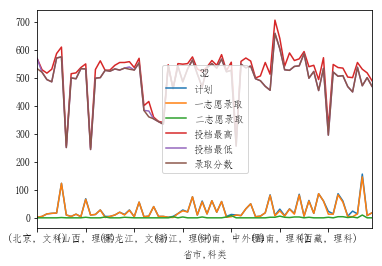

In [12]:
#绘图依旧存在问题
excout.plot()
plt.show()

### 提取制图数据

In [13]:
multisum=excout['计划'].groupby(excout['省市']).sum()
multisum['山东']=8207
multisum

省市
上海       10
云南       60
内蒙古      40
北京        7
吉林       40
四川      100
天津       30
宁夏      170
安徽       96
山西      100
广东       10
广西      100
新疆       26
江苏       50
江西       75
河北      150
河南      105
浙江       50
海南       40
湖北       40
湖南       50
甘肃       60
福建       70
西藏       23
贵州      170
辽宁       40
重庆       40
陕西      100
青海       30
黑龙江      60
山东     8207
Name: 计划, dtype: int64

In [14]:
num_list=list(multisum.values)
city_list=list(multisum.index)

### 绘制区域图

In [15]:
map= Map('2016级山科来自各省人数', title_color="#fff", title_pos="center", width=650,  height=600, background_color='#404a59')

In [16]:
attr=city_list
value=num_list
map.add("", attr, value, visual_range=[0, 200], visual_text_color="#fff",
        symbol_size=30, is_visualmap=True,is_label_show=True)

## 多份文件的处理

In [17]:
name_tp=('山东科技大学二〇一五年录取情况统计表.xls',
           '山东科技大学二〇一四年录取情况统计表.xls',
           '山东科技大学二〇一三年录取情况统计表.xls')
num_in=(30,28,23)
num_out=(33,31,26)

In [18]:
#处理函数
def data_deal(name,num_in,num_out):
    #省内处理
    exc=pd.read_excel(name)
    exc['Unnamed: 3'][0]='科类二'
    excin = exc[0:num_in]
    excin.columns=excin.iloc[0]
    excin=excin.drop([0,])
    excin=excin[['科类','科类二','计划','录取','投档最高','投档最低','录取\n分数','平均']]
    excin['科类']=excin['科类'].fillna(method='ffill')
    excin['投档最高']=excin['投档最高'].fillna(method='ffill')
    excin['投档最低']=excin['投档最低'].fillna(method='ffill')
    #使用多级index
    excin.index=[excin['科类'],excin['科类二']]
    del excin['科类'],excin['科类二']
    #省外处理
    excout = exc[num_out:]
    excout.columns=excout.iloc[0]
    excout=excout.drop([num_out])
    excout[['省码','省市','批次']]=excout[['省码','省市','批次']].fillna(method='ffill')
    excout = excout.fillna(method='ffill',axis=1)
    excout.index = [excout['省市'],excout['科类']]
    del excout['省码'],excout['科类']
    
    return excin,excout

### 通过pd.concat融合成一个dataframe

In [19]:
multisum=excout['计划'].groupby(excout['省市']).sum()
for d,i,o in zip(name_tp,num_in,num_out):
    excin,excout=data_deal(d,i,o)
    ser=excout['计划'].groupby(excout['省市']).sum()
    multisum=pd.concat([multisum,ser],axis=1)
multisum=multisum.fillna(0)
multisum.columns=[2016,2015,2014,2013]
multisum

,2016,2015,2014,2013
上海,10,10,10,10.0
云南,60,60,60,0.0
内蒙古,40,40,40,40.0
北京,7,9,9,9.0
吉林,40,40,40,40.0
四川,100,70,70,70.0
天津,30,30,30,30.0
宁夏,170,124,124,110.0
安徽,96,145,130,110.0
山西,100,110,120,85.0


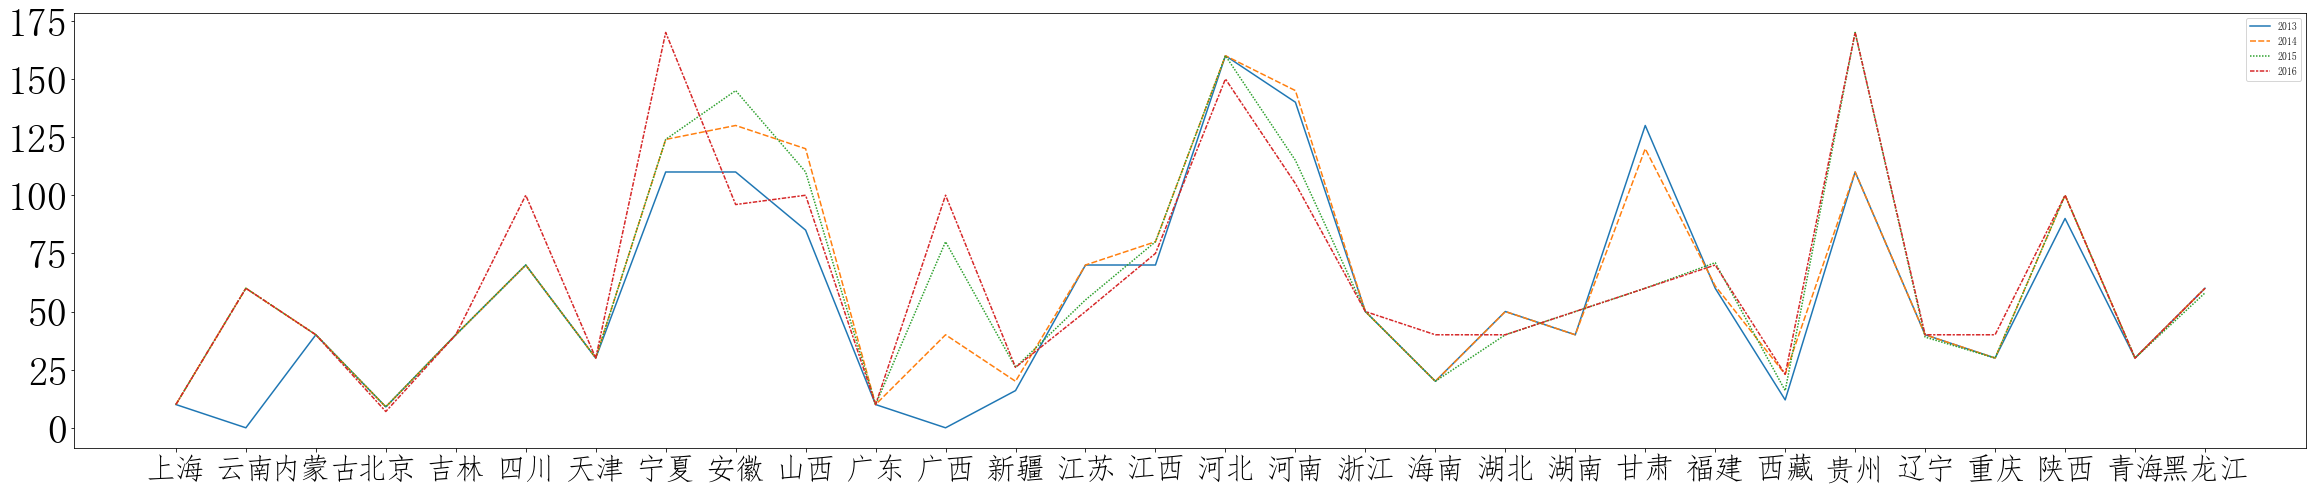

In [27]:

plt.figure(figsize=(40,8))
sns.lineplot(data=multisum)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

plt.show()